In [1]:
# import the necessary packages
import os
import cv2
import json
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, auc, confusion_matrix, accuracy_score

In [4]:
print("[INFO] packages loaded")
mask_directory = '/content/drive/MyDrive/Colab Notebooks/binary_images_per_class_small'

model_filename = '/content/drive/MyDrive/Colab Notebooks/knn_model.joblib'
confusion_filename='/content/drive/MyDrive/Colab Notebooks/knn_confusion_matrix.png'
results_filename='/content/drive/MyDrive/Colab Notebooks/knn_model.xlsx'
class_report_filename='/content/drive/MyDrive/Colab Notebooks/knn_classification_report.png'
roc_filename='/content/drive/MyDrive/Colab Notebooks/knn_roc_curve.png'
pr_filename='/content/drive/MyDrive/Colab Notebooks/knn_pr_curve.png'

print('[INFO] initialized directories... starting iteration')
# Initialize list to hold data
X = []
y = []

[INFO] packages loaded
[INFO] initialized directories... starting iteration


In [5]:
# Iterate through category directories
for category in os.listdir(mask_directory):
    category_path = os.path.join(mask_directory, category)

    # Check if it is a directory
    if os.path.isdir(category_path):
        # Iterate through mask files in the category directory
        for mask_file in os.listdir(category_path):
            if mask_file.endswith('.png'):  # Ensure it's a mask file
                mask_file_path = os.path.join(category_path, mask_file)

                # Read the mask image
                mask_image = cv2.imread(mask_file_path, cv2.IMREAD_GRAYSCALE)
                mask_image = cv2.resize(mask_image, (300, 300))

                # Convert the mask to binary (0s and 1s)
                binary_mask=mask_image // 255

                # Flatten the binary mask to 1D array
                flattened_mask = binary_mask.flatten().astype(int)
                X.append(flattened_mask)
                y.append(category)

X=np.array(X)
y=np.array(y)

print('[INFO] done iteration loop per images. Stored data in arrays. Start on encoding and partitioning')

[INFO] done iteration loop per images. Stored data in arrays. Start on encoding and partitioning


In [6]:
# encode the labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
(trainX, testX, trainY, testY) = train_test_split(X, y_encoded,
	test_size=0.3, random_state=42)

print('[INFO] encoded and partitioned data. Setting up GridSearchCV with Stratified validation for model training')

param_grid={
    'n_neighbors': [1, 3, 5, 7, 9],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

knn = KNeighborsClassifier()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(knn, param_grid=param_grid, scoring='accuracy',
                           cv=skf, refit='accuracy', n_jobs=-1)

[INFO] encoded and partitioned data. Setting up GridSearchCV with Stratified validation for model training


In [7]:
print('[INFO] done setting up GridSearchCV. starting grid search training')
grid_search.fit(X, y)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model=grid_search.best_estimator_

print('[INFO] done fitting data to model. Doing performance and prediction checks.')

#### FOR PREDICTION CHECK
try:
    y_pred=best_model.predict(testX)
    y_pred_encoded=le.fit_transform(y_pred)
    accuracy = accuracy_score(testY, y_pred_encoded)
    print(f"[RESULTS] Accuracy of Best Model on Given Test Set: {accuracy:.3f}")
except Exception as e:
    print(f"[ERROR] {e}")

[INFO] done setting up GridSearchCV. starting grid search training
[INFO] done fitting data to model. Doing performance and prediction checks.
[RESULTS] Accuracy of Best Model on Given Test Set: 1.000


In [8]:
#### FOR PERFORMANCE CHECK
try:
    print(f"[RESULTS] Best parameters: {best_params}")
    print(f"[RESULTS] Best score: {best_score}")
    cm=confusion_matrix(testY, y_pred_encoded)
    print("[RESULTS] Confustion Matrix on Given Test Set:")
    print(cm)
except Exception as e:
    print(f'[ERROR] failed to print confusion matrix results: {e}')

try:
    print("[RESULTS] Classification Report on Given Test Set:")
    print(classification_report(testY, y_pred_encoded, target_names=le.classes_))
    print(grid_search.cv_results_)
    joblib.dump(best_model, model_filename)
    print('[INFO] model saved')
except Exception as e:
    print(f'[ERROR] failed to print classification report OR save model: {e}')

try:
    cv_results_df = pd.DataFrame(grid_search.cv_results_)
    cv_results_df.to_excel(results_filename, index=False)
    print(f'[INFO] grid search results saved to {results_filename}')
except Exception as e:
    print(f'[ERROR] failed to save grid search results: {e}')

[RESULTS] Best parameters: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
[RESULTS] Best score: 0.9870880054366292
[RESULTS] Confustion Matrix on Given Test Set:
[[12  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  0]
 [ 0  0  0  0 23  0  0  0  0]
 [ 0  0  0  0  0 32  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0 16  0]
 [ 0  0  0  0  0  0  0  0 15]]
[RESULTS] Classification Report on Given Test Set:
                   precision    recall  f1-score   support

            chair       1.00      1.00      1.00        12
computer_keyboard       1.00      1.00      1.00         8
   computer_mouse       1.00      1.00      1.00        18
             door       1.00      1.00      1.00        14
      door_handle       1.00      1.00      1.00        23
     light_switch       1.00      1.00      1.00        32
          monitor       1.00      1.00      1.00        25
           person       1.

In [11]:
### VISUALIZATION
#Create a Confusion Matrix
try:
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(confusion_filename, bbox_inches='tight')
    plt.close()
    print(f'[INFO] Saved Confusion Matrix on {confusion_filename}')
except Exception as e:
    print(f'[ERROR] failed to save confusion_matrix results: {e}')

# Save classification report
try:
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(pd.DataFrame(classification_report(testY, y_pred_encoded, target_names=le.classes_, output_dict=True)).iloc[:-1, :].T,
                annot=True, cmap='viridis', ax=ax)
    ax.set_title('Classification Report')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Target Names')
    plt.savefig(class_report_filename, bbox_inches='tight')
    plt.close()
    print(f'[INFO] Saved Classification Report on {class_report_filename}')
except Exception as e:
    print(f'[ERROR] failed to save classifcation report results: {e}')

[INFO] Saved Confusion Matrix on /content/drive/MyDrive/Colab Notebooks/knn_confusion_matrix.png
[INFO] Saved Classification Report on /content/drive/MyDrive/Colab Notebooks/knn_classification_report.png


[INFO] Saved Confusion Matrix on /content/drive/MyDrive/Colab Notebooks/rf_confusion_matrix.png
[ERROR] failed to save ROC curve results: y should be a 1d array, got an array of shape (163, 9) instead.
[ERROR] failed to save precision-recall curve results: name 'y_pred_encoded_1' is not defined
[ERROR] failed to save classifcation report results: name 'y_pred_encoded_1' is not defined


<Figure size 640x480 with 0 Axes>

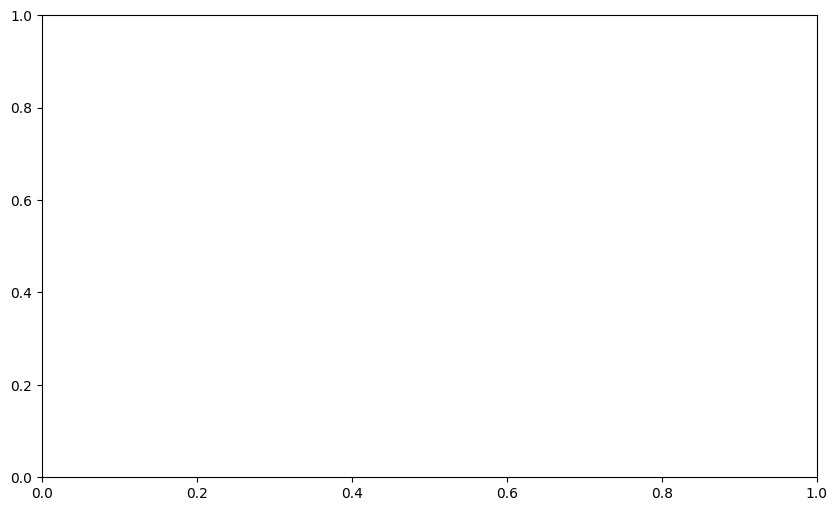

In [ ]:
# Create a ROC curve
try:
  y_pred_1=best_model.predict_proba(testX)
  y_pred_encoded_1=le.fit_transform(y_pred_1)
  n_classes = len(np.unique(testY))
  testY_binarized = label_binarize(testY, classes=np.unique(testY))
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testY_binarized[:, i], y_pred_encoded_1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Plot all ROC curves
  plt.figure()
  for i in range(n_classes):
      plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random chance')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for Multi-Class')
  plt.legend(loc='best')
  plt.savefig(roc_filename, bbox_inches='tight')
  plt.close()
  print(f'[INFO] Saved ROC Curve on {roc_filename}')
except Exception as e:
  print(f'[ERROR] failed to save ROC curve results: {e}')

# Create a precision-recall curve
try:
  plt.figure()
  for i in range(n_classes):
      precision, recall, _ = precision_recall_curve(testY_binarized[:, i], y_pred_encoded_1[:, i])
      plt.plot(recall, precision, label='Precision-Recall curve of class {0}'.format(i))

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve for Multi-Class')
  plt.legend(loc='best')
  plt.savefig(pr_filename, bbox_inches='tight')
  plt.close()
  print(f'[INFO] Saved Precision-Recall Curve on {pr_filename}')
except Exception as e:
  print(f'[ERROR] failed to save precision-recall curve results: {e}')

# Optional: Load the model (demonstration of how to load the saved model)
# model = joblib.load(model_filename)
# print("Model loaded successfully")
# print(classification_report(testY, model.predict(testX), target_names=le.classes_))

In [ ]:
from google.colab import runtime
runtime.unassign()